In [48]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import h5py
from matplotlib.pyplot import figure

from keras.callbacks import ModelCheckpoint
import numpy as np
from Bio import SeqIO
from numpy import array
from numpy import argmax
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.backend import expand_dims
import matplotlib.pyplot as plt
from keras.regularizers import l1, l2
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [49]:
def read_h5(path):
    hf = h5py.File(path, 'r')
    mat = np.array(hf["embedding"])
    hf.close()
    return mat

In [50]:
bfd_tr_pos = read_h5("../data/train/dataframe/prot_t5_xl_bfd_features_pos.h5")
bfd_tr_pos

array([[ 0.2785141 , -0.08357751, -0.02512945, ...,  0.26282382,
        -0.01890585, -0.12005087],
       [-0.10928973, -0.18422587, -0.02087241, ...,  0.00987901,
        -0.13280961, -0.04204367],
       [ 0.29931065, -0.13563909, -0.01892212, ...,  0.05163218,
         0.08015401, -0.29067376],
       ...,
       [ 0.23390867, -0.10793954,  0.24293354, ...,  0.1887087 ,
        -0.18978666, -0.31415093],
       [ 0.09375427, -0.12966889,  0.24086781, ...,  0.18249437,
        -0.19982688, -0.24683475],
       [ 0.29931065, -0.13563909, -0.01892212, ...,  0.05163218,
         0.08015401, -0.29067376]], dtype=float32)

In [51]:
bfd_tr_neg = read_h5("../data/train/dataframe/prot_t5_xl_bfd_features_neg.h5")
bfd_tr_neg

array([[ 0.26102892, -0.0895055 , -0.06183824, ...,  0.02661107,
        -0.06064121, -0.19048871],
       [ 0.3571574 , -0.07405978, -0.01010159, ...,  0.09829358,
        -0.07028277, -0.21768837],
       [ 0.17423435, -0.11714823, -0.01763457, ...,  0.14945517,
        -0.01573938, -0.18901984],
       ...,
       [ 0.09375427, -0.12966889,  0.24086781, ...,  0.18249437,
        -0.19982688, -0.24683475],
       [ 0.26102892, -0.0895055 , -0.06183824, ...,  0.02661107,
        -0.06064121, -0.19048871],
       [ 0.21183425, -0.06905835, -0.14004318, ...,  0.10986412,
         0.0356342 , -0.0899203 ]], dtype=float32)

In [53]:
def get_input_for_embedding(fasta_file):
    encodings = []
    
    # define universe of possible input values
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    
    for seq_record in SeqIO.parse(fasta_file, "fasta"):
        data = seq_record.seq
        for char in data:
            if char not in alphabet:
                return
        integer_encoded = [char_to_int[char] for char in data]
        encodings.append(integer_encoded)
    encodings = np.array(encodings)
    return encodings

test_positive_embedding = get_input_for_embedding('../data/test/fasta/test_positive_sites.fasta')
test_negative_embedding = get_input_for_embedding('../data/test/fasta/test_negative_sites.fasta')
train_positive_embedding = get_input_for_embedding('../data/train/fasta/positive_sites.fasta')
train_negative_embedding = get_input_for_embedding('../data/train/fasta/negative_sites.fasta')


# create labels
train_positive_labels = np.ones(train_positive_embedding.shape[0])
train_negative_labels = np.zeros(train_negative_embedding.shape[0])
test_positive_labels = np.ones(test_positive_embedding.shape[0])
test_negative_labels = np.zeros(test_negative_embedding.shape[0])


# stack positive and negative data together
X_train_full_embedding = np.vstack((train_positive_embedding,train_negative_embedding))
X_test_embedding = np.vstack((test_positive_embedding,test_negative_embedding))
y_train_full = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)
y_test = np.concatenate((test_positive_labels, test_negative_labels), axis = 0)

train_positive_pt5 = pd.read_csv("../data/train/features/train_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
train_negative_pt5 = pd.read_csv("../data/train/features/train_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
#test_positive_pt5 = pd.read_csv("../data/test/features/test_positive_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]
#test_negative_pt5 = pd.read_csv("../data/test/features/test_negative_ProtT5-XL-UniRef50.csv", header = None).iloc[:,2:]


# stack positive and negative data together
X_train_pt5_full = np.vstack((train_positive_pt5, train_negative_pt5))
#X_test_pt5 = np.vstack((test_positive_pt5,test_negative_pt5))

In [57]:
train_positive_labels = np.ones(bfd_tr_pos.shape[0])
train_negative_labels = np.zeros(bfd_tr_neg.shape[0])
y_train_full = np.concatenate((train_positive_labels, train_negative_labels), axis = 0)

X_train_full_embedding = np.vstack((bfd_tr_pos, bfd_tr_neg))

X_train_full_embedding.shape, y_train_full.shape

((9499, 1024), (9499,))

[Text(0.5, 1.0, 'T-SNE projection')]

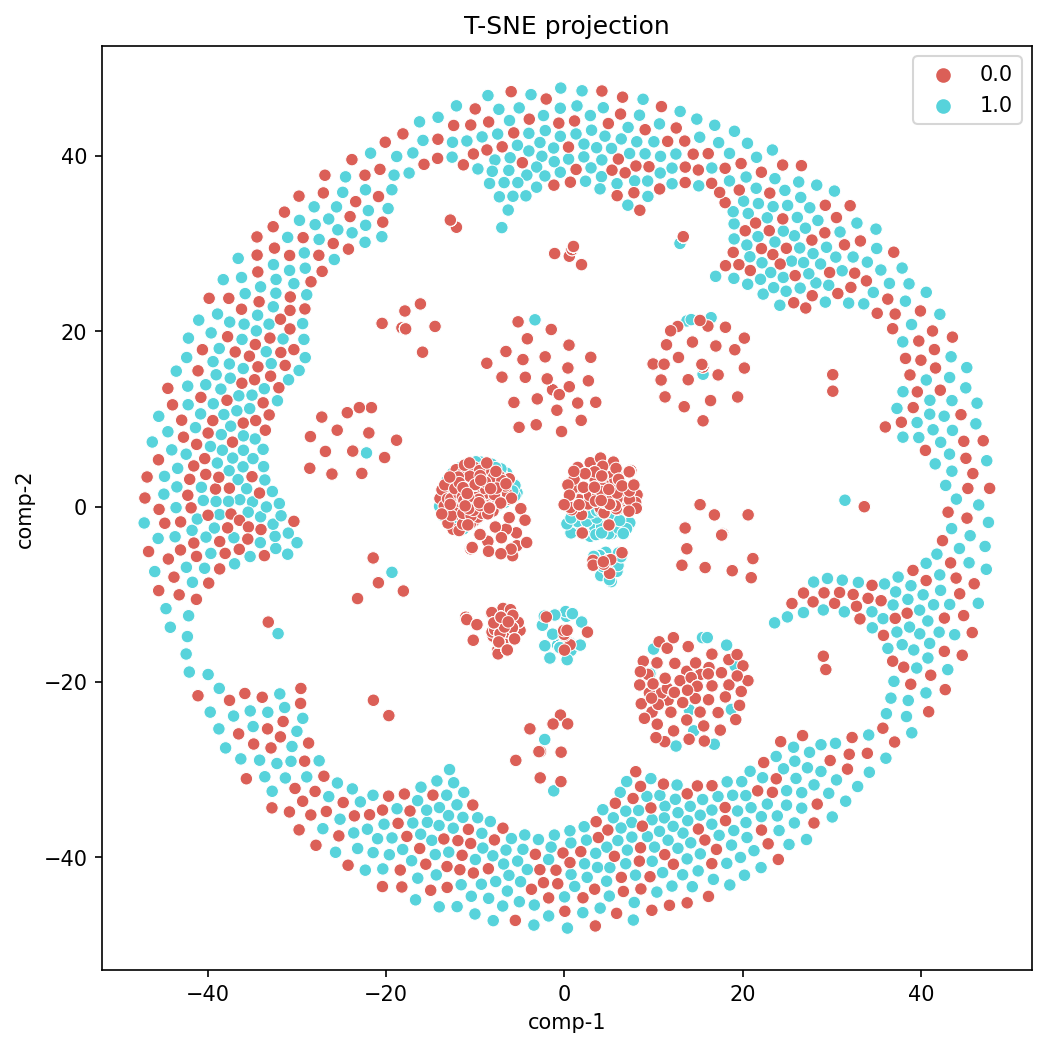

In [60]:
perplexity = 2
learning_rate = 20
n_colors = 2
figsize = (8, 8)

figure(figsize=figsize, dpi=150)

z = TSNE(n_components=2, init='random', learning_rate = 20, perplexity=perplexity).fit_transform(X_train_full_embedding)

df = pd.DataFrame()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=y_train_full, palette=sns.color_palette("hls", n_colors), data=df).set(title="T-SNE projection")